I'm a beginner, so please be gentle with me.

In [1]:
import os
# os.chdir('INPUT YOUR LOCAL DIR')

# DataSet & Library Loading

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import time, gc

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [4]:
class CFG:
    min_batch_size = 10_000  # max_batch_sizeの1000分の1程度が限界か
    max_batch_size = 100_000  # 大きいほどVRAMを食う
    batch_increase_rate = 2  # batch_sizeを変動させるときの係数
    epochs = 10_000  # 最大のepoch数
    folds = 10  # クロスバリデーションにおけるfold数
    seed = 42  # TODO 機能させる
    target = 'target'  # 目標変数
    model_path = "models"  # モデルを保存するフォルダ
    test_pred = []  # 各foldで作ったモデル別の、testを予測した結果のカラム名
    pred = 'pred'  # trainを予測した結果のカラム名
    increase_batch = 9999  # 何epoch間lossが改善しなかったbatchを増やすか
    early_stopping = 100  # 何epochでearly stoppingをするか
    lr = 1  # optimizerの学習率
    # min_lr = 1e-3  # 学習率の最低値
    lr_patience = 10  # 学習率を引き下げる間隔
    lr_factor = 0.5  # lrを何倍にするか
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    delta = 1e-4  # AUC等がいくつ変わらなかったら学習などをやめるか

In [5]:
os.makedirs(CFG.model_path, exist_ok=True)

## FE

In [6]:
# データセット読み込み
df_train = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv")
df_sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")
display(df_train.head())
display(df_test.head())
display(df_sub.head())

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,...,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,...,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,...,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
3,900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,...,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
4,900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,...,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


,id,target
0,900000,0.5
1,900001,0.5
2,900002,0.5
3,900003,0.5
4,900004,0.5


In [7]:
display(df_train.shape)
display(df_test.shape)

(900000, 33)

(700000, 32)

In [8]:
from matplotlib.colors import ListedColormap

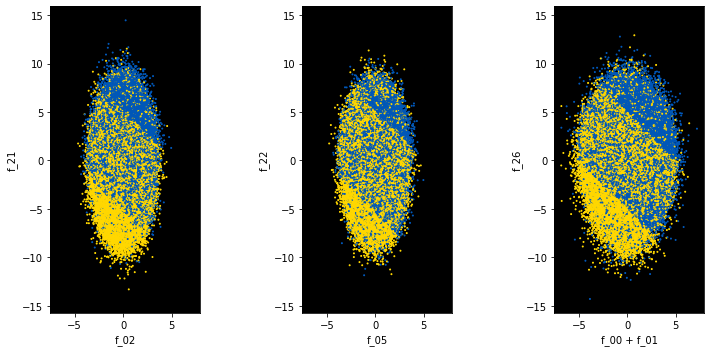

In [9]:
# https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras
plt.rcParams['axes.facecolor'] = 'k'
plt.figure(figsize=(11, 5))
cmap = ListedColormap(["#ffd700", "#0057b8"])

ax = plt.subplot(1, 3, 1)
ax.scatter(df_train['f_02'], df_train['f_21'], s=1,
           c=df_train.target, cmap=cmap)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(df_train['f_05'], df_train['f_22'], s=1,
           c=df_train.target, cmap=cmap)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(df_train['f_00'] + df_train['f_01'], df_train['f_26'], s=1,
           c=df_train.target, cmap=cmap)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue

In [10]:
df_all = pd.concat([df_train, df_test])

In [11]:
df_all['i_02_21'] = (df_all.f_21 + df_all.f_02 > 5.2).astype(int) - (df_all.f_21 + df_all.f_02 < -5.3).astype(int)
df_all['i_05_22'] = (df_all.f_22 + df_all.f_05 > 5.1).astype(int) - (df_all.f_22 + df_all.f_05 < -5.4).astype(int)
i_00_01_26 = df_all.f_00 + df_all.f_01 + df_all.f_26
df_all['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)

In [12]:
# 不要データを削除
df_all.drop(['id'], axis=1, inplace=True)

In [13]:
# NA埋め
df_all.fillna(df_all.mean(numeric_only=True), inplace=True)

In [14]:
# f_27を分解
def splitter(text):
    arr = tuple(text)
    return arr

column_list = ['f_27_' + str(i) for i in range(10)]
df_all[column_list] = df_all.apply(lambda x: splitter(x['f_27']), axis=1, result_type='expand')

In [15]:
# 新設したf_27を分解したものを、one-hot-encoding
# メモリがやばいのでやめる
# new_df = pd.get_dummies(df_all[column_list])
# df_all = pd.concat([df_all, new_df], axis=1)

In [16]:
# f_27_0~9を数値に
for column in column_list:
    df_all[column] = df_all[column].apply(lambda x: ord(x)-ord('A'))

In [17]:
# f_27_0~9の各種統計量を求める

df_all['f_27_mean'] =  df_all[column_list].mean(axis=1)
df_all['f_27_std'] =  df_all[column_list].std(axis=1)
df_all['f_27_sm'] = df_all['f_27_std'] / (df_all['f_27_mean']+0.001)


In [18]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()

In [19]:
from tqdm import tqdm

In [20]:
# とても遅い
def c2i(c):
    return ord(c)-ord('A')

def calc_linear_regression(txt):
    arr = [c2i(c) for c in txt]
    y = np.array(arr).reshape(-1, 1)
    x = np.arange(len(y)).reshape(-1, 1)
    lrm.fit(x, y)
    return pd.Series([lrm.coef_[0].item(), lrm.intercept_.item()])
tqdm.pandas()
df_all[['lr_a', 'lr_b']] = df_all['f_27'].progress_apply(calc_linear_regression)

100%|██████████| 1600000/1600000 [14:32<00:00, 1834.28it/s]


In [21]:
# f_27に出てくる文字が、何種類あるかを返す
def calc_cnt_of(txt):
    from collections import Counter
    cnt_of = Counter(list(txt))
    return len(cnt_of)

df_all['len_cnt_of'] = df_all['f_27'].apply(calc_cnt_of)

In [22]:
# f_27に各文字が何回出てくるかを数える
def calc_char_cnt(txt):
    from collections import Counter
    import string
    cnt_of = Counter(list(txt))
    ret = []
    for c in string.ascii_uppercase:
        ret.append(cnt_of[c])
    return tuple(ret)

import string
column_list = []
for c in string.ascii_uppercase:
    column_list.append('f_27_cnt_' + c)

df_all[column_list] = df_all.apply(lambda x: calc_char_cnt(x['f_27']), axis=1, result_type='expand')

In [23]:
# 不要になったカテゴリ変数を削除
df_all.drop(['f_27'], axis=1, inplace=True)

In [24]:
# この時点で数値しかない。正規化
scaler = StandardScaler()
for column in df_all.columns:
    if column == CFG.target:
        continue
    if df_all[column].dtype == 'object':
        continue
    df_all[column] = scaler.fit_transform(df_all[column].values.reshape(-1, 1))

In [25]:
df_train = df_all[:len(df_train)]
df_test = df_all[len(df_train):]

In [26]:
df_train.to_pickle('train_fe.pkl')
df_test.to_pickle('test_fe.pkl')

In [27]:
del df_all

# Pytorch

In [28]:
df_train = pd.read_pickle('train_fe.pkl')
df_test = pd.read_pickle('test_fe.pkl')

## Define Pytorch Model

In [29]:
class Net1(nn.Module):
    def __init__(self, input_size, output_size):
        # 7層
        super(Net1, self).__init__()
        self.first_bn = nn.BatchNorm1d(input_size, momentum=0.01)  # とりあえず入れてみた。momentumが小さいといいことあるんかな・・？
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 384)
        self.bn2 = nn.BatchNorm1d(384)
        self.fc3 = nn.Linear(384, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.fc7 = nn.Linear(32, output_size)
        self.bn7 = nn.BatchNorm1d(output_size)

    def forward(self, x):
        # dropoutの後にbnを置いてはならない
        # nbは、活性化関数の前に置く
        x = self.first_bn(x)
        x = F.silu(self.bn1((self.fc1(x))))
        x = F.silu(self.bn2((self.fc2(x))))
        x = F.silu(self.bn3((self.fc3(x))))
        x = F.silu(self.bn4((self.fc4(x))))
        x = F.silu(self.bn5((self.fc5(x))))
        x = F.silu(self.bn6((self.fc6(x))))
        x = self.bn7((self.fc7(x)))
        return x

# Pytorch Loss Function

In [30]:
criterion = nn.BCEWithLogitsLoss()

# Pytorch Training

In [31]:
class LossChecker:
    # 指定した回数、loss等が改善されていなければTrueを返す
    def __init__(self, patience=20, strategy="min", delta=1e-6):
        self.patience = patience
        self.bef_epoch = 0
        self.strategy = strategy
        self.delta = delta
        if strategy == "max":
            self.val = -float('inf')
        else:
            self.val = float('inf')

    def step(self, epoch, loss):
        if self.strategy == "max":
            if self.val < loss:
                self.val = loss + self.delta
                self.bef_epoch = epoch
            if epoch - self.bef_epoch > self.patience:
                self.bef_epoch = epoch
                return True
            else:
                return False
        else:
            if self.val > loss:
                self.val = loss - self.delta
                self.bef_epoch = epoch
            if epoch - self.bef_epoch > self.patience:
                self.bef_epoch = epoch
                return True
            else:
                return False


In [32]:
# 学習の対象とする特徴量を列挙する
all_features = df_train.columns.tolist()
all_features.remove(CFG.target)

In [33]:
class CalcBatchSize:
    # バッチサイズを
    # 極大->ちょっと減少->最小->ちょっと増加->ちょっと増加->...の順で遷移させる
    # あんまり意味なさそう・・・というか悪影響しかなさそう
    def __init__(self, min_batch_size, max_batch_size, rate=1.2):
        self.min_batch_size = min_batch_size
        self.max_batch_size = max_batch_size
        self.current_batch_size = max_batch_size
        self.cnt = -1
        self.rate = rate
        self.state = 0  # 0->初回、 1->増加、 -1->現象

    def step(self):
        if self.state == 0:
            self.state = -1
            return self.current_batch_size
        elif self.state == -1:
            # minに到達するまで、減少させる
            self.current_batch_size = int(self.current_batch_size/self.rate)
            self.current_batch_size = max(self.current_batch_size, self.min_batch_size)
        else:
            # 増加させ続ける
            self.current_batch_size = int(self.current_batch_size*self.rate)+1
            self.current_batch_size = min(self.current_batch_size, self.max_batch_size)
        if self.current_batch_size == self.min_batch_size:
            self.state = 1
        return self.current_batch_size
            

In [34]:
def fit(Net, n_splits, df_train, df_test, model_name_prefix):
    # TODO 引数を調整する

    df_train = df_train.sample(frac=1).reset_index(drop=True)  # df_trainをシャッフル

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CFG.seed)

    for fold, (train_index, valid_index) in enumerate(skf.split(df_train, df_train[CFG.target])):
        print('-----', fold, '-----')
        # fold毎に初期化する設定
        # model, optimizer, scheduler, その他変数
        model = Net(len(all_features), 1).to(CFG.device)
        print(model)

        optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
        # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, factor=CFG.lr_factor, min_lr=CFG.min_lr, patience=CFG.lr_patience)
        calc_batch_size = CalcBatchSize(CFG.min_batch_size, CFG.max_batch_size, CFG.batch_increase_rate)
        batch_size = calc_batch_size.step()
        early_stopping = LossChecker(CFG.early_stopping, "max", CFG.delta)
        increase_batch = LossChecker(CFG.increase_batch, "max", CFG.delta)

        train_loss_min = np.Inf
        auc_max = -np.Inf

        # データを分割する。fold毎に一回だけやる
        X_train = df_train[all_features].iloc[train_index]
        y_train = df_train.iloc[train_index][CFG.target]
        X_valid = df_train[all_features].iloc[valid_index]
        y_valid = df_train.iloc[valid_index][CFG.target]
        X_test = df_test[all_features]
        st_time = time.time()

        for epoch in range(CFG.epochs):
            train_loss_list = []

            # TODO Variableを使うのは古いらしい
            # TODO 元データがメモリに収まらず、pklで管理している場合でも動くようにする
            # ここら辺見て実装する
            # https://tips-memo.com/python-dataset-memory
            # https://qiita.com/mathlive/items/2a512831878b8018db02
            # https://tma15.github.io/blog/2020/03/08/pytorch-dataset%E3%81%AE%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%81%BF%E3%81%AB%E3%81%8B%E3%81%8B%E3%82%8B%E3%83%A1%E3%83%A2%E3%83%AA%E6%B6%88%E8%B2%BB%E9%87%8F%E3%82%92%E7%AF%80%E7%B4%84%E3%81%99%E3%82%8B/
            x0_var = Variable(torch.FloatTensor(X_train.values))   # GPUで送るのはこっちのほうが早いが、VRAMの浪費になると思う
            y0_var = Variable(torch.FloatTensor(y_train.values))
            x_valid_var = Variable(torch.FloatTensor(X_valid.values)).to(CFG.device)  # valid_dataはちっちゃいので、最初に送っちゃう
            i = -1
            while True:
                i += 1
                # ミニバッチ学習
                start = i * batch_size
                end   = start + batch_size
                x_var = x0_var[start:end].to(CFG.device)  # GPUで送るのはこっちのほうが遅いが、VRAMの節約になると思う
                y_var = y0_var[start:end].to(CFG.device)
                if len(x_var) == 1:
                    print("len(x_var) == 1, cant use bn layer. skip this batch")
                    break
                if len(x_var) == 0:
                    # not need to train
                    break

                optimizer.zero_grad()
                output = model(x_var).squeeze(1)
                loss   = criterion(output, y_var)
                loss.backward()
                optimizer.step()

                train_loss_list.append(loss.item())
                if np.isnan(loss.item()):
                    print('-----nan-----')
                    print(loss.item(), torch.isnan(output).any(), torch.isnan(y_var).any())
                    raise "ERROR loss.item() is nan"

            # 学習終了
            # validで予測して、評価する
            pred = torch.sigmoid(model(x_valid_var))
            auc = roc_auc_score(y_valid, pred.data.cpu().numpy())
            train_loss = sum(train_loss_list)/len(train_loss_list)

            # auc
            if auc >= auc_max+CFG.delta:
                print("Epoch: " + str(epoch+1).zfill(5), "batch_size: " + str(batch_size), "Loss:{:6f}".format(train_loss), "AUC increased ({:6f} ===> {:6f})".format(auc_max,auc), ". Saving the model...")
                torch.save(model.state_dict(), CFG.model_path + "/" + model_name_prefix + "model" + str(fold) + ".pt")
                auc_max = auc

            # aucがしばらく更新されていない場合は、バッチサイズを変える  良いバッチサイズを探すのに使えるかも?
            if increase_batch.step(epoch, auc):
                batch_size = calc_batch_size.step()
                print('change batch', batch_size)
            
            # aucがしばらく更新されていない場合は、停止する
            if early_stopping.step(epoch, auc):
                if batch_size != calc_batch_size.max_batch_size:
                    print('wait for batch_size reach', calc_batch_size.max_batch_size)
                else:
                    print('early stopping', "Epoch:", epoch, "Loss:{:6f}".format(train_loss))
                    break

            # log
            if epoch % 200 == 0:
                print('')
                print("Epoch: " + str(epoch+1), "batch_size: " + str(batch_size), "AUC: {}".format(auc), "Loss: {}".format(train_loss), "Time per epoch:", (time.time() - st_time)/(epoch+1))

        print('STOP train fold=', fold)
        # 保存した最も良いモデルを読み込み、validデータを予測しなおす
        model.load_state_dict(torch.load(CFG.model_path + "/" + model_name_prefix + "model" + str(fold) + ".pt",))
        x0_var = Variable(torch.FloatTensor(X_valid.values)).to(CFG.device)
        pred = torch.sigmoid(model(x0_var))
        df_train.loc[valid_index, CFG.pred] = pred.data.cpu().numpy()
        auc = roc_auc_score(df_train.loc[valid_index, CFG.target], df_train.loc[valid_index, CFG.pred])
        print('fold', fold, 'AUC:', auc)

        del model, optimizer, X_train, y_train, X_valid, y_valid, X_test, x0_var, y0_var, x_var, y_var, pred
        gc.collect()

    auc = roc_auc_score(df_train[CFG.target], df_train[CFG.pred])
    print('-----', 'Training Ended!', '-----')
    print('AUC', auc)

In [35]:
gc.collect()
torch.cuda.empty_cache()  # 意味ないかも・・・

In [36]:
fit(Net1, 10, df_train, df_test, "Net1")

----- 0 -----
Net1(
  (first_bn): BatchNorm1d(75, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=75, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=384, bias=True)
  (bn2): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=384, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (bn6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track

# predictions

In [37]:
import glob

In [38]:
models = np.sort(glob.glob(f"./{CFG.model_path}/*.pt"))
print(models)
# fold別に作った10個のモデルをロードする
with torch.no_grad():
    for i, model_name in enumerate(models):
        model = Net1(len(all_features), 1).to(CFG.device)
        model.load_state_dict(torch.load(model_name,))
        X_test = df_test[all_features]
        x0_var = Variable(torch.FloatTensor(X_test.values)).to(CFG.device)
        pred = F.sigmoid(model(x0_var))
        col_name = "pred" + str(i)
        CFG.test_pred.append(col_name)
        df_test[col_name] = pred.data.cpu().numpy()

df_test.head()


['./models/Net1model0.pt' './models/Net1model1.pt'
 './models/Net1model2.pt' './models/Net1model3.pt'
 './models/Net1model4.pt' './models/Net1model5.pt'
 './models/Net1model6.pt' './models/Net1model7.pt'
 './models/Net1model8.pt' './models/Net1model9.pt']


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9
0,0.442942,0.174343,-0.999880,0.762541,0.186806,-1.074689,0.501289,2.396549,2.477530,-1.442584,...,0.999989,0.999998,0.999984,0.999989,0.999998,0.999964,0.999967,0.999999,0.999990,0.999998
1,-0.605708,-0.306574,0.626907,-0.577935,-1.751495,1.355544,-0.191672,-0.622672,0.592269,1.000518,...,0.999950,0.999973,0.999976,0.999965,0.999955,0.999870,0.999918,0.999995,0.999956,0.999990
2,0.304344,2.448961,0.245918,0.818000,0.359811,-1.331750,1.358225,0.585017,0.592269,1.000518,...,0.000011,0.000045,0.000028,0.000007,0.000025,0.000001,0.000052,0.000009,0.000020,0.000007
3,0.154331,0.260235,-1.366999,-0.092634,-1.111402,-0.948400,1.118767,-1.226516,-1.292992,1.000518,...,0.000137,0.000183,0.000015,0.000023,0.000019,0.000059,0.000072,0.000090,0.000057,0.000009
4,-1.652549,-0.425328,-0.667563,-0.321384,-0.089518,0.181743,1.784686,-0.018827,-0.036151,-0.221033,...,0.999339,0.992459,0.999543,0.999884,0.999957,0.998474,0.999160,0.999646,0.999643,0.999941


In [39]:
df_sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")
df_sub[CFG.target] = df_test[CFG.test_pred].mean(axis=1)

In [40]:
# df_sub[CFG.target] = (df_sub[CFG.target] > 0.5).astype(int)

In [41]:
df_sub.to_csv('submission.csv', index=False)

In [42]:
df_sub.head(10)

,id,target
0,900000,0.999988
1,900001,0.999955
2,900002,0.000021
3,900003,0.000066
4,900004,0.998805
5,900005,0.005635
6,900006,0.089053
7,900007,0.999996
8,900008,0.004963
9,900009,0.999887
